Libraries

In [8]:
import torch
import torch.nn as nn
import snntorch as snn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns   
from matplotlib.patches import Rectangle
import math

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

FasionMNIST Data set loader 

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

train_data = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Creating SNN

In [10]:
def create_snn(layer_sizes, beta, dropout_rate=0.1):
    """
    Create SNN with variable number of layers and improved architecture
    """
    class SNNModel(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.layers = nn.ModuleList()
            self.lif_layers = nn.ModuleList()
            self.dropout_layers = nn.ModuleList()
            
            # Input layer
            input_size = 28 * 28
            for i, hidden_size in enumerate(layer_sizes):
                self.layers.append(nn.Linear(input_size, hidden_size))
                self.lif_layers.append(snn.Leaky(beta=beta))
                # Add dropout for regularization (except last layer)
                if i < len(layer_sizes) - 1:
                    self.dropout_layers.append(nn.Dropout(dropout_rate))
                else:
                    self.dropout_layers.append(nn.Identity())
                input_size = hidden_size
            
            # Output layer (now 10 classes for FashionMNIST)
            self.layers.append(nn.Linear(input_size, 10))
            self.lif_layers.append(snn.Leaky(beta=beta))

        def forward(self, x, num_steps=15):  # Increased time steps
            # Initialize membrane potentials for all layers
            mem_states = [lif.init_leaky() for lif in self.lif_layers]
            spk_out = 0
            
            for step in range(num_steps):
                current_input = x.view(x.size(0), -1)
                
                # Forward through all layers
                for i, (layer, lif, dropout) in enumerate(zip(self.layers, self.lif_layers, self.dropout_layers + [nn.Identity()])):
                    current = layer(current_input)
                    spike, mem_states[i] = lif(current, mem_states[i])
                    if i < len(self.layers) - 1:  # Apply dropout except on output
                        spike = dropout(spike)
                    current_input = spike
                
                spk_out += current_input
            
            return spk_out / num_steps
    
    return SNNModel()


Creating mutation

In [ ]:
def create_individual_with_depth():
    """Create individual with improved parameter ranges"""
    num_hidden_layers = random.randint(2, 5)  # Reduced max depth for stability
    
    # Create layer sizes with tapering (wider to narrower)
    layer_sizes = []
    base_size = random.uniform(128, 256)  # Start with wider layers
    
    for i in range(num_hidden_layers):
        # Gradually reduce size for deeper layers
        reduction_factor = 0.7 ** i
        size = max(32, base_size * reduction_factor + random.uniform(-20, 20))
        layer_sizes.append(size)
    
    beta = random.uniform(0.7, 0.95)  # Narrower beta range
    lr = random.uniform(0.001, 0.005)  # Narrower LR range
    dropout = random.uniform(0.0, 0.2)  # Add dropout parameter
    
    individual = [num_hidden_layers] + layer_sizes + [beta, lr, dropout]
    return individual

def bounded_mutation_with_depth(individual, mu=0, sigma=0.15, indpb=0.15):
    """Improved mutation with smaller perturbations"""
    num_layers = int(individual[0])
    
    # Mutate number of layers (lower probability)
    if random.random() < 0.08:  # Reduced probability
        new_num_layers = max(2, min(4, num_layers + random.choice([-1, 1])))
        
        if new_num_layers > num_layers:
            # Add a new layer (smaller than previous)
            prev_size = individual[num_layers] if num_layers > 0 else 128
            new_layer_size = max(32, prev_size * 0.7 + random.uniform(-10, 10))
            individual.insert(num_layers + 1, new_layer_size)
        elif new_num_layers < num_layers:
            individual.pop(num_layers)
        
        individual[0] = new_num_layers
        num_layers = new_num_layers
    
    # Mutate layer sizes with smaller perturbations
    for i in range(1, num_layers + 1):
        if random.random() < indpb:
            individual[i] += random.gauss(mu, sigma * 30)  # Smaller mutations
            individual[i] = max(32, min(256, individual[i]))
    
    # Mutate beta
    if random.random() < indpb:
        individual[num_layers + 1] += random.gauss(mu, sigma * 0.05)
        individual[num_layers + 1] = max(0.7, min(0.95, individual[num_layers + 1]))
    
    # Mutate learning rate
    if random.random() < indpb:
        individual[num_layers + 2] += random.gauss(mu, sigma * 0.001)
        individual[num_layers + 2] = max(0.001, min(0.005, individual[num_layers + 2]))
    
    # Mutate dropout
    if random.random() < indpb:
        individual[num_layers + 3] += random.gauss(mu, sigma * 0.05)
        individual[num_layers + 3] = max(0.0, min(0.2, individual[num_layers + 3]))
    
    return individual,

def crossover_with_depth(ind1, ind2):
    """Improved crossover for variable-length individuals"""
    num_layers1 = int(ind1[0])
    num_layers2 = int(ind2[0])
    
    # Choose depth more intelligently (favor successful depths)
    if hasattr(ind1, 'fitness') and hasattr(ind2, 'fitness'):
        if ind1.fitness.valid and ind2.fitness.valid:
            if ind1.fitness.values[0] > ind2.fitness.values[0]:
                chosen_depth = num_layers1
            else:
                chosen_depth = num_layers2
        else:
            chosen_depth = random.choice([num_layers1, num_layers2])
    else:
        chosen_depth = random.choice([num_layers1, num_layers2])
    
    # Create new individuals
    new_ind1 = [chosen_depth]
    new_ind2 = [chosen_depth]
    
    # Blend layer sizes
    for i in range(chosen_depth):
        if i < num_layers1 and i < num_layers2:
            # Blend existing layers
            alpha = random.uniform(0.3, 0.7)  # Less extreme blending
            size1 = alpha * ind1[1 + i] + (1 - alpha) * ind2[1 + i]
            size2 = (1 - alpha) * ind1[1 + i] + alpha * ind2[1 + i]
        elif i < num_layers1:
            size1 = ind1[1 + i] + random.uniform(-10, 10)
            size2 = random.uniform(32, 128)
        elif i < num_layers2:
            size1 = random.uniform(32, 128)
            size2 = ind2[1 + i] + random.uniform(-10, 10)
        else:
            size1 = random.uniform(64, 128)
            size2 = random.uniform(64, 128)
        
        new_ind1.append(max(32, min(256, size1)))
        new_ind2.append(max(32, min(256, size2)))
    
    # Blend other parameters
    alpha = random.uniform(0.3, 0.7)
    beta1 = alpha * ind1[num_layers1 + 1] + (1 - alpha) * ind2[num_layers2 + 1]
    beta2 = (1 - alpha) * ind1[num_layers1 + 1] + alpha * ind2[num_layers2 + 1]
    lr1 = alpha * ind1[num_layers1 + 2] + (1 - alpha) * ind2[num_layers2 + 2]
    lr2 = (1 - alpha) * ind1[num_layers1 + 2] + alpha * ind2[num_layers2 + 2]
    dropout1 = alpha * ind1[num_layers1 + 3] + (1 - alpha) * ind2[num_layers2 + 3]
    dropout2 = (1 - alpha) * ind1[num_layers1 + 3] + alpha * ind2[num_layers2 + 3]
    
    new_ind1.extend([beta1, lr1, dropout1])
    new_ind2.extend([beta2, lr2, dropout2])
    
    ind1[:] = new_ind1
    ind2[:] = new_ind2
    
    return ind1, ind2

def evaluate_model_with_depth(individual):
    """Improved evaluation with more training and better metrics"""
    try:
        # Parse individual
        num_layers = int(individual[0])
        layer_sizes = [max(32, min(256, int(round(individual[i])))) 
                       for i in range(1, num_layers + 1)]
        beta = max(0.7, min(0.95, float(individual[num_layers + 1])))
        lr = max(0.001, min(0.005, float(individual[num_layers + 2])))
        dropout = max(0.0, min(0.2, float(individual[num_layers + 3])))
        
        model = create_snn(layer_sizes, beta, dropout)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        loss_fn = nn.CrossEntropyLoss()

        # Extended training loop
        model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, targets)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
            
            # Train on more batches based on network depth
            max_batches = min(50, 30 + num_layers * 5)
            if batch_idx >= max_batches:
                break

        # More comprehensive evaluation
        model.eval()
        correct, total = 0, 0
        eval_loss = 0
        
        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(test_loader):
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = loss_fn(outputs, targets)
                eval_loss += loss.item()
                
                _, pred = outputs.max(1)
                total += targets.size(0)
                correct += (pred == targets).sum().item()
                
                # Evaluate on more samples for better accuracy
                if total >= 2000:  # Increased from 1000
                    break
        
        accuracy = correct / total
        avg_train_loss = total_loss / num_batches
        avg_eval_loss = eval_loss / min(batch_idx + 1, len(test_loader))
        
        # Penalize overfitting and complexity
        complexity_penalty = num_layers * 0.001 + sum(layer_sizes) * 0.00001
        overfitting_penalty = max(0, avg_train_loss - avg_eval_loss) * 0.1
        
        final_fitness = accuracy - overfitting_penalty
        
        return (final_fitness,)
    
    except Exception as e:
        print(f"Error evaluating individual: {e}")
        return (0.0,)  # Return poor fitness for failed evaluations

def parse_individual(individual):
    """Helper function to parse individual parameters"""
    num_layers = int(individual[0])
    layer_sizes = [int(round(individual[i])) for i in range(1, num_layers + 1)]
    beta = individual[num_layers + 1]
    lr = individual[num_layers + 2]
    dropout = individual[num_layers + 3]
    return num_layers, layer_sizes, beta, lr, dropout

def print_best_individual(generation, best_individual, fitness):
    """Print detailed information about the best individual"""
    num_layers, layer_sizes, beta, lr, dropout = parse_individual(best_individual)
    
    print(f"\n{'='*60}")
    print(f"GENERATION {generation} - BEST INDIVIDUAL")
    print(f"{'='*60}")
    print(f"Fitness: {fitness:.6f}")
    print(f"Architecture: 784 → {' → '.join(map(str, layer_sizes))} → 10")
    print(f"Beta (β): {beta:.4f}")
    print(f"Learning Rate: {lr:.6f}")
    print(f"Dropout Rate: {dropout:.4f}")
    print(f"Total Parameters: ~{sum([784] + layer_sizes + [10]) * sum(layer_sizes + [10]):,}")
    print(f"{'='*60}")

Creating Plotting

In [12]:
def plot_evolution_progress(logbook, generation_best):
    """Plot evolution progress with multiple metrics"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Extract data
    generations = [record['gen'] for record in logbook]
    max_fitness = [record['max'] for record in logbook]
    avg_fitness = [record['avg'] for record in logbook]
    min_fitness = [record['min'] for record in logbook]
    std_fitness = [record['std'] for record in logbook]
    
    # Plot 1: Fitness Evolution
    ax1.plot(generations, max_fitness, 'r-', linewidth=2, label='Max Fitness', marker='o')
    ax1.plot(generations, avg_fitness, 'b-', linewidth=2, label='Avg Fitness', marker='s')
    ax1.fill_between(generations, 
                     [avg - std for avg, std in zip(avg_fitness, std_fitness)],
                     [avg + std for avg, std in zip(avg_fitness, std_fitness)],
                     alpha=0.3, color='blue')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness')
    ax1.set_title('Evolution Progress - Fitness Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Best Fitness Trajectory
    best_gens = [item[0] for item in generation_best]
    best_fits = [item[2] for item in generation_best]
    ax2.plot(best_gens, best_fits, 'g-', linewidth=3, marker='*', markersize=8)
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Best Fitness')
    ax2.set_title('Best Individual Fitness Trajectory')
    ax2.grid(True, alpha=0.3)
    
    # Annotate improvements
    for i in range(1, len(best_fits)):
        if best_fits[i] > best_fits[i-1]:
            ax2.annotate(f'↑ {best_fits[i]:.4f}', 
                        xy=(best_gens[i], best_fits[i]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Plot 3: Fitness Distribution
    try:
        final_gen_data = [ind.fitness.values[0] for ind in logbook[-1]['population'] 
                          if hasattr(ind, 'fitness') and ind.fitness.valid]
    except KeyError:
        final_gen_data = [max_fitness[-1], avg_fitness[-1], min_fitness[-1]]
    
    ax3.hist(final_gen_data, bins=15, alpha=0.7, color='purple', edgecolor='black')
    ax3.axvline(np.mean(final_gen_data), color='red', linestyle='--', 
                label=f'Mean: {np.mean(final_gen_data):.4f}')
    ax3.set_xlabel('Fitness')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Final Generation Fitness Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Convergence Analysis
    improvement_rate = []
    for i in range(1, len(max_fitness)):
        rate = max_fitness[i] - max_fitness[i-1]
        improvement_rate.append(rate)
    
    ax4.plot(generations[1:], improvement_rate, 'orange', linewidth=2, marker='d')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.set_xlabel('Generation')
    ax4.set_ylabel('Fitness Improvement')
    ax4.set_title('Convergence Rate (Generation-to-Generation Improvement)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evolution_progress.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_architecture_evolution(generation_best):
    """Plot architecture evolution over generations"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Extract architecture data
    generations = []
    num_layers_list = []
    layer_sizes_by_gen = []
    total_params = []
    
    for gen, individual, fitness in generation_best:
        generations.append(gen)
        num_layers, layer_sizes, beta, lr, dropout = parse_individual(individual)
        num_layers_list.append(num_layers)
        layer_sizes_by_gen.append(layer_sizes)
        
        # Calculate approximate parameter count
        params = 784 * layer_sizes[0]  # Input to first hidden
        for i in range(len(layer_sizes) - 1):
            params += layer_sizes[i] * layer_sizes[i + 1]
        params += layer_sizes[-1] * 10  # Last hidden to output
        total_params.append(params)
    
    # Plot 1: Number of Layers Evolution
    ax1.plot(generations, num_layers_list, 'b-o', linewidth=2, markersize=8)
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Number of Hidden Layers')
    ax1.set_title('Architecture Depth Evolution')
    ax1.set_ylim(1.5, 4.5)
    ax1.grid(True, alpha=0.3)
    
    # Annotate layer changes
    for i in range(1, len(num_layers_list)):
        if num_layers_list[i] != num_layers_list[i-1]:
            change = "+" if num_layers_list[i] > num_layers_list[i-1] else "-"
            ax1.annotate(f'{change}Layer', 
                        xy=(generations[i], num_layers_list[i]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue'),
                        arrowprops=dict(arrowstyle='->'))
    
    # Plot 2: Layer Sizes Heatmap
    max_layers = max(len(sizes) for sizes in layer_sizes_by_gen)
    heatmap_data = np.zeros((len(generations), max_layers))
    
    for i, sizes in enumerate(layer_sizes_by_gen):
        for j, size in enumerate(sizes):
            heatmap_data[i, j] = size
    
    im = ax2.imshow(heatmap_data.T, cmap='viridis', aspect='auto', interpolation='nearest')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Layer Index')
    ax2.set_title('Layer Sizes Evolution Heatmap')
    ax2.set_xticks(range(0, len(generations), max(1, len(generations)//10)))
    ax2.set_xticklabels(generations[::max(1, len(generations)//10)])
    plt.colorbar(im, ax=ax2, label='Layer Size')
    
    # Plot 3: Total Parameters Evolution
    ax3.plot(generations, total_params, 'r-s', linewidth=2, markersize=6)
    ax3.set_xlabel('Generation')
    ax3.set_ylabel('Total Parameters')
    ax3.set_title('Model Complexity Evolution')
    ax3.grid(True, alpha=0.3)
    
    # Format y-axis to show K/M notation
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K' if x < 1000000 else f'{x/1000000:.1f}M'))
    
    # Plot 4: Architecture Visualization for Best Individual
    best_individual = max(generation_best, key=lambda x: x[2])
    _, best_layer_sizes, _, _, _ = parse_individual(best_individual[1])
    
    # Create network diagram
    ax4.set_xlim(0, 10)
    ax4.set_ylim(0, 10)
    
    # Draw layers
    layer_positions = np.linspace(1, 9, len(best_layer_sizes) + 2)  # +2 for input and output
    all_sizes = [784] + best_layer_sizes + [10]
    
    max_neurons = max(all_sizes)
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_sizes)))
    
    for i, (pos, size, color) in enumerate(zip(layer_positions, all_sizes, colors)):
        # Scale rectangle height based on layer size
        height = (size / max_neurons) * 6 + 1
        y_center = 5
        
        rect = Rectangle((pos - 0.3, y_center - height/2), 0.6, height, 
                        facecolor=color, edgecolor='black', alpha=0.7)
        ax4.add_patch(rect)
        
        # Add labels
        if i == 0:
            label = f'Input\n{size}'
        elif i == len(all_sizes) - 1:
            label = f'Output\n{size}'
        else:
            label = f'H{i}\n{size}'
        
        ax4.text(pos, y_center - height/2 - 0.5, label, ha='center', va='top', fontsize=8)
        
        # Draw connections
        if i < len(layer_positions) - 1:
            ax4.arrow(pos + 0.3, y_center, 0.4, 0, head_width=0.1, 
                     head_length=0.1, fc='gray', ec='gray', alpha=0.5)
    
    ax4.set_title(f'Best Architecture (Gen {best_individual[0]}, Fitness: {best_individual[2]:.4f})')
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['bottom'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('architecture_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_beta_evolution(generation_best):
    """Plot beta parameter evolution and analysis"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Extract parameter data
    generations = []
    betas = []
    learning_rates = []
    dropouts = []
    fitnesses = []
    
    for gen, individual, fitness in generation_best:
        generations.append(gen)
        num_layers, layer_sizes, beta, lr, dropout = parse_individual(individual)
        betas.append(beta)
        learning_rates.append(lr)
        dropouts.append(dropout)
        fitnesses.append(fitness)
    
    # Plot 1: Beta Evolution
    ax1.plot(generations, betas, 'purple', linewidth=3, marker='o', markersize=8)
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Beta Value')
    ax1.set_title('Beta Parameter Evolution')
    ax1.set_ylim(0.65, 1.0)
    ax1.grid(True, alpha=0.3)
    
    # Highlight significant changes
    for i in range(1, len(betas)):
        if abs(betas[i] - betas[i-1]) > 0.05:
            ax1.annotate(f'β={betas[i]:.3f}', 
                        xy=(generations[i], betas[i]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->'))
    
    # Plot 2: Learning Rate Evolution
    ax2.plot(generations, learning_rates, 'green', linewidth=3, marker='s', markersize=6)
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Learning Rate Evolution')
    ax2.grid(True, alpha=0.3)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # Plot 3: Parameter Correlation with Fitness
    # Create scatter plot with color coding for generations
    scatter = ax3.scatter(betas, fitnesses, c=generations, cmap='viridis', 
                         s=100, alpha=0.7, edgecolors='black')
    ax3.set_xlabel('Beta Value')
    ax3.set_ylabel('Fitness')
    ax3.set_title('Beta vs Fitness Correlation')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Generation')
    
    # Add trend line
    z = np.polyfit(betas, fitnesses, 1)
    p = np.poly1d(z)
    ax3.plot(betas, p(betas), "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    ax3.legend()
    
    # Plot 4: All Parameters Over Time
    # Normalize parameters to [0, 1] for comparison
    norm_betas = [(b - min(betas)) / (max(betas) - min(betas)) for b in betas]
    norm_lrs = [(lr - min(learning_rates)) / (max(learning_rates) - min(learning_rates)) for lr in learning_rates]
    norm_dropouts = [(d - min(dropouts)) / (max(dropouts) - min(dropouts)) if max(dropouts) > min(dropouts) else 0.5 for d in dropouts]
    
    ax4.plot(generations, norm_betas, 'purple', linewidth=2, marker='o', label='Beta (normalized)')
    ax4.plot(generations, norm_lrs, 'green', linewidth=2, marker='s', label='Learning Rate (normalized)')
    ax4.plot(generations, norm_dropouts, 'orange', linewidth=2, marker='^', label='Dropout (normalized)')
    
    ax4.set_xlabel('Generation')
    ax4.set_ylabel('Normalized Parameter Value')
    ax4.set_title('All Parameters Evolution (Normalized)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('beta_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_comprehensive_summary_plot(logbook, generation_best):
    """Create a comprehensive summary plot with key metrics"""
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
    
    # Extract all data
    generations = [record['gen'] for record in logbook]
    max_fitness = [record['max'] for record in logbook]
    avg_fitness = [record['avg'] for record in logbook]
    
    gen_data = []
    fitness_data = []
    beta_data = []
    lr_data = []
    layers_data = []
    param_counts = []
    
    for gen, individual, fitness in generation_best:
        gen_data.append(gen)
        fitness_data.append(fitness)
        num_layers, layer_sizes, beta, lr, dropout = parse_individual(individual)
        beta_data.append(beta)
        lr_data.append(lr)
        layers_data.append(num_layers)
        
        # Calculate parameters
        params = 784 * layer_sizes[0]
        for i in range(len(layer_sizes) - 1):
            params += layer_sizes[i] * layer_sizes[i + 1]
        params += layer_sizes[-1] * 10
        param_counts.append(params)
    
    # Main fitness plot (spans 2 columns)
    ax_main = fig.add_subplot(gs[0, :2])
    ax_main.plot(generations, max_fitness, 'r-', linewidth=3, label='Population Max', marker='o', markersize=6)
    ax_main.plot(generations, avg_fitness, 'b-', linewidth=2, label='Population Avg', alpha=0.7)
    ax_main.plot(gen_data, fitness_data, 'g-', linewidth=3, label='Best Individual', marker='*', markersize=10)
    ax_main.set_xlabel('Generation', fontsize=12)
    ax_main.set_ylabel('Fitness', fontsize=12)
    ax_main.set_title('Evolution Summary - Fitness Progression', fontsize=14, fontweight='bold')
    ax_main.legend(fontsize=11)
    ax_main.grid(True, alpha=0.3)
    
    # Best individual info (right column, top)
    ax_info = fig.add_subplot(gs[0, 2])
    ax_info.axis('off')
    best_idx = fitness_data.index(max(fitness_data))
    best_gen = gen_data[best_idx]
    best_fitness = fitness_data[best_idx]
    best_individual = generation_best[best_idx][1]
    
    _, best_layers, best_beta, best_lr, best_dropout = parse_individual(best_individual)
    
    info_text = f"""BEST INDIVIDUAL
    
Generation: {best_gen}
Fitness: {best_fitness:.6f}

Architecture:
• Layers: {len(best_layers)}
• Sizes: {best_layers}
• Parameters: ~{param_counts[best_idx]:,}

Parameters:
• Beta: {best_beta:.4f}
• Learning Rate: {best_lr:.6f}
• Dropout: {best_dropout:.4f}"""
    
    ax_info.text(0.05, 0.95, info_text, transform=ax_info.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    # Architecture depth evolution
    ax_depth = fig.add_subplot(gs[1, 0])
    ax_depth.plot(gen_data, layers_data, 'purple', linewidth=2, marker='s', markersize=6)
    ax_depth.set_xlabel('Generation')
    ax_depth.set_ylabel('Number of Layers')
    ax_depth.set_title('Architecture Depth')
    ax_depth.grid(True, alpha=0.3)
    ax_depth.set_ylim(1.5, 4.5)
    
    # Parameter count evolution
    ax_params = fig.add_subplot(gs[1, 1])
    ax_params.plot(gen_data, param_counts, 'orange', linewidth=2, marker='^', markersize=6)
    ax_params.set_xlabel('Generation')
    ax_params.set_ylabel('Parameters')
    ax_params.set_title('Model Complexity')
    ax_params.grid(True, alpha=0.3)
    ax_params.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
    
    # Beta evolution
    ax_beta = fig.add_subplot(gs[1, 2])
    ax_beta.plot(gen_data, beta_data, 'red', linewidth=2, marker='o', markersize=6)
    ax_beta.set_xlabel('Generation')
    ax_beta.set_ylabel('Beta Value')
    ax_beta.set_title('Beta Parameter')
    ax_beta.grid(True, alpha=0.3)
    ax_beta.set_ylim(0.65, 1.0)
    
    # Performance vs complexity scatter
    ax_scatter = fig.add_subplot(gs[2, 0])
    scatter = ax_scatter.scatter(param_counts, fitness_data, c=gen_data, cmap='viridis', 
                               s=100, alpha=0.7, edgecolors='black')
    ax_scatter.set_xlabel('Parameter Count')
    ax_scatter.set_ylabel('Fitness')
    ax_scatter.set_title('Performance vs Complexity')
    ax_scatter.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax_scatter, label='Generation')
    
    # Learning rate evolution
    ax_lr = fig.add_subplot(gs[2, 1])
    ax_lr.plot(gen_data, lr_data, 'green', linewidth=2, marker='d', markersize=6)
    ax_lr.set_xlabel('Generation')
    ax_lr.set_ylabel('Learning Rate')
    ax_lr.set_title('Learning Rate Evolution')
    ax_lr.grid(True, alpha=0.3)
    ax_lr.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # Improvement rate
    ax_improve = fig.add_subplot(gs[2, 2])
    improvement_rate = [0]  # First generation has no improvement
    for i in range(1, len(fitness_data)):
        improvement_rate.append(fitness_data[i] - fitness_data[i-1])
    
    colors = ['red' if x < 0 else 'green' for x in improvement_rate[1:]]
    ax_improve.bar(gen_data[1:], improvement_rate[1:], color=colors, alpha=0.7)
    ax_improve.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax_improve.set_xlabel('Generation')
    ax_improve.set_ylabel('Fitness Improvement')
    ax_improve.set_title('Generation-to-Generation Progress')
    ax_improve.grid(True, alpha=0.3)
    
    # Final statistics summary
    ax_stats = fig.add_subplot(gs[3, :])
    ax_stats.axis('off')
    
    # Calculate statistics
    total_improvement = fitness_data[-1] - fitness_data[0] if len(fitness_data) > 1 else 0
    avg_improvement = total_improvement / len(fitness_data) if len(fitness_data) > 1 else 0
    best_improvement_gen = improvement_rate.index(max(improvement_rate[1:])) + 1 if len(improvement_rate) > 1 else 0
    
    convergence_gen = len(fitness_data)
    for i in range(len(fitness_data) - 5, 0, -1):
        if abs(fitness_data[i] - fitness_data[-1]) > 0.001:
            convergence_gen = i + 5
            break
    
    stats_text = f"""EVOLUTION STATISTICS
    
Total Generations: {len(fitness_data)}                    Total Improvement: {total_improvement:.6f}                    Average per Generation: {avg_improvement:.6f}
    
Best Generation: {best_gen}                    Convergence: ~Gen {convergence_gen}                    Best Improvement: Gen {best_improvement_gen} (+{max(improvement_rate[1:]) if len(improvement_rate) > 1 else 0:.6f})

Architecture Range: {min(layers_data)}-{max(layers_data)} layers          Parameter Range: {min(param_counts):,}-{max(param_counts):,}          Beta Range: {min(beta_data):.3f}-{max(beta_data):.3f}"""
    
    ax_stats.text(0.5, 0.5, stats_text, transform=ax_stats.transAxes, fontsize=12,
                 horizontalalignment='center', verticalalignment='center',
                 bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow', alpha=0.8))
    
    plt.suptitle('SNN Evolution Comprehensive Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.savefig('comprehensive_evolution_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

Set Up DEAP

In [13]:

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

def create_individual():
    """Create an individual and wrap it in creator.Individual"""
    ind_data = create_individual_with_depth()
    return creator.Individual(ind_data)

toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_model_with_depth)
toolbox.register("mate", crossover_with_depth)
toolbox.register("mutate", bounded_mutation_with_depth, mu=0, sigma=0.1, indpb=0.15)
toolbox.register("select", tools.selTournament, tournsize=3)

/usr/local/python/3.12.1/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/python/3.12.1/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Running the Evolution

Starting Evolution...

GENERATION 0 - BEST INDIVIDUAL
Fitness: 0.682036
Architecture: 784 → 198 → 131 → 10
Beta (β): 0.9300
Learning Rate: 0.001855
Dropout Rate: 0.0259
Total Parameters: ~380,697

Gen 0 Stats:
 gen	nevals	avg     	max     	min     	std     
0  	400   	0.440033	0.682036	0.147436	0.132737

--- Processing Generation 1 ---

GENERATION 1 - BEST INDIVIDUAL
Fitness: 0.682036
Architecture: 784 → 198 → 131 → 10
Beta (β): 0.9300
Learning Rate: 0.001855
Dropout Rate: 0.0259
Total Parameters: ~380,697
Gen 1 
Stats: 1  	263   	0.574327	0.682036	0.402865	0.0570505

--- Processing Generation 2 ---

GENERATION 2 - BEST INDIVIDUAL
Fitness: 0.682189
Architecture: 784 → 199 → 131 → 10
Beta (β): 0.8579
Learning Rate: 0.002061
Dropout Rate: 0.0862
Total Parameters: ~382,160
Gen 2 
Stats: 2  	276   	0.612665	0.682189	0.542041	0.0331777

--- Processing Generation 3 ---

GENERATION 3 - BEST INDIVIDUAL
Fitness: 0.682851
Architecture: 784 → 198 → 125 → 10
Beta (β): 0.8748
Learning Rate: 0.00144

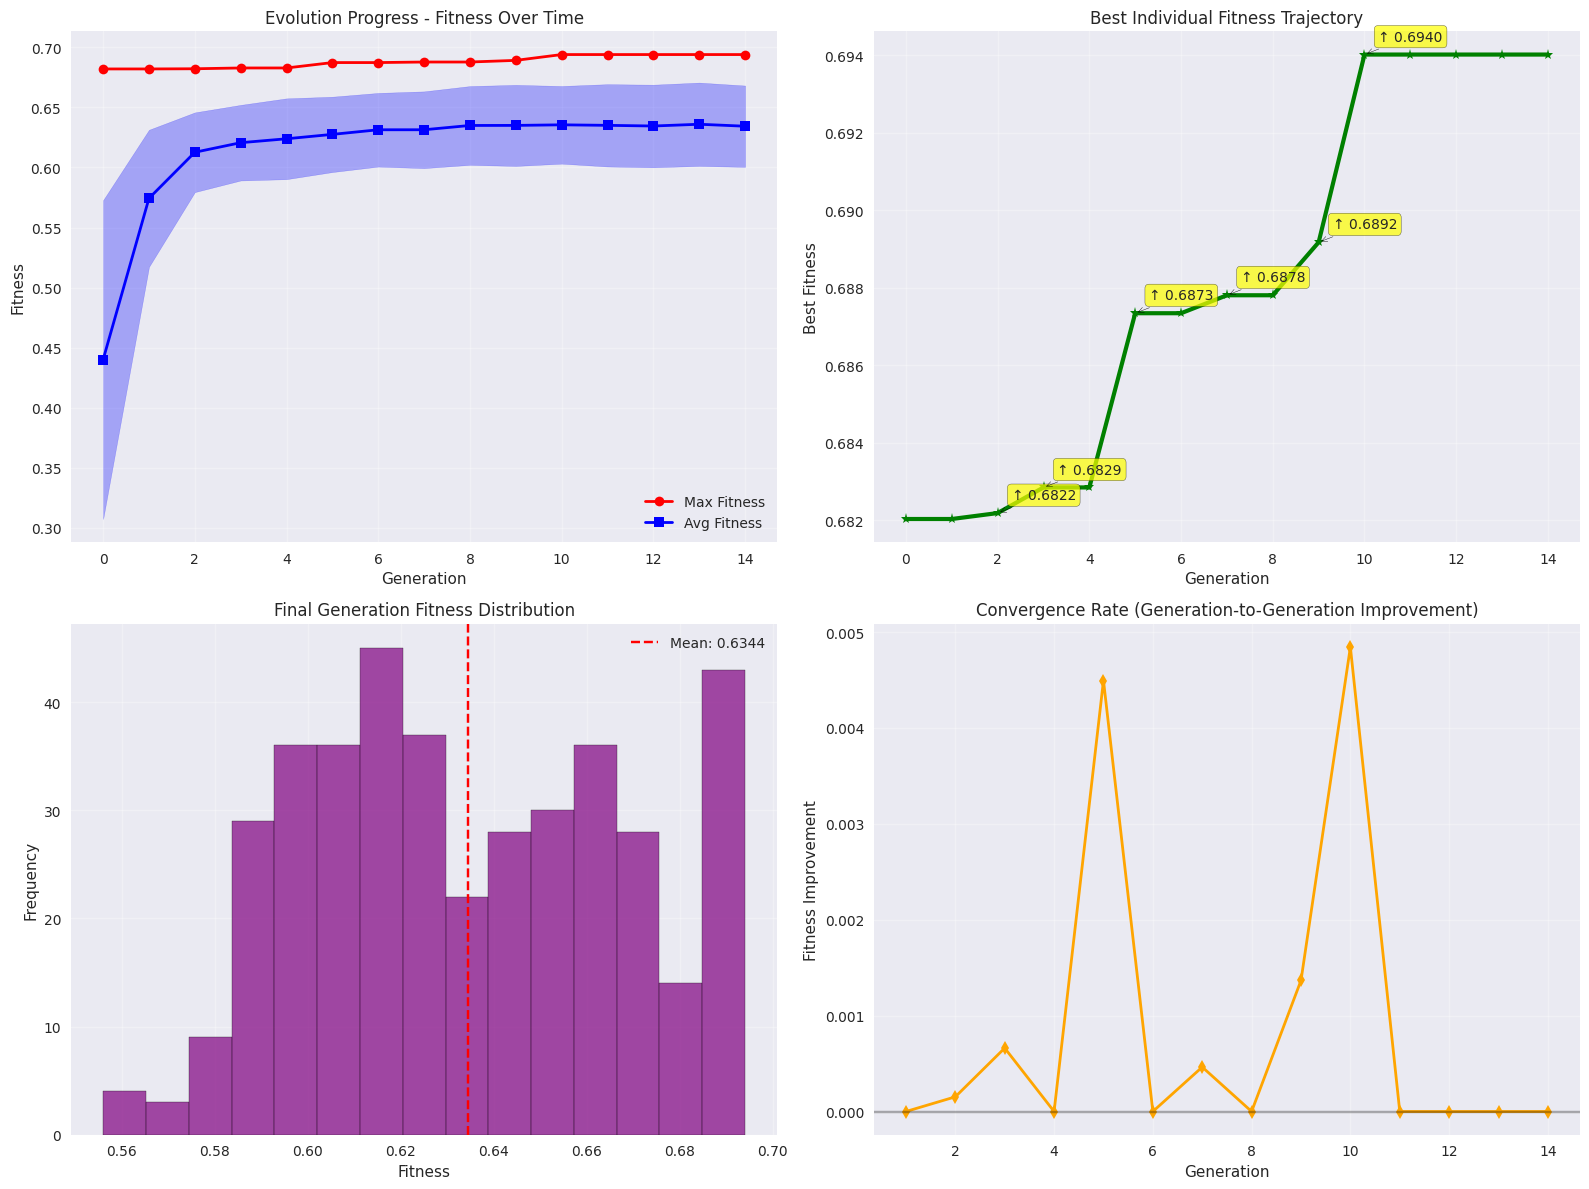

2. Architecture Evolution Plot...


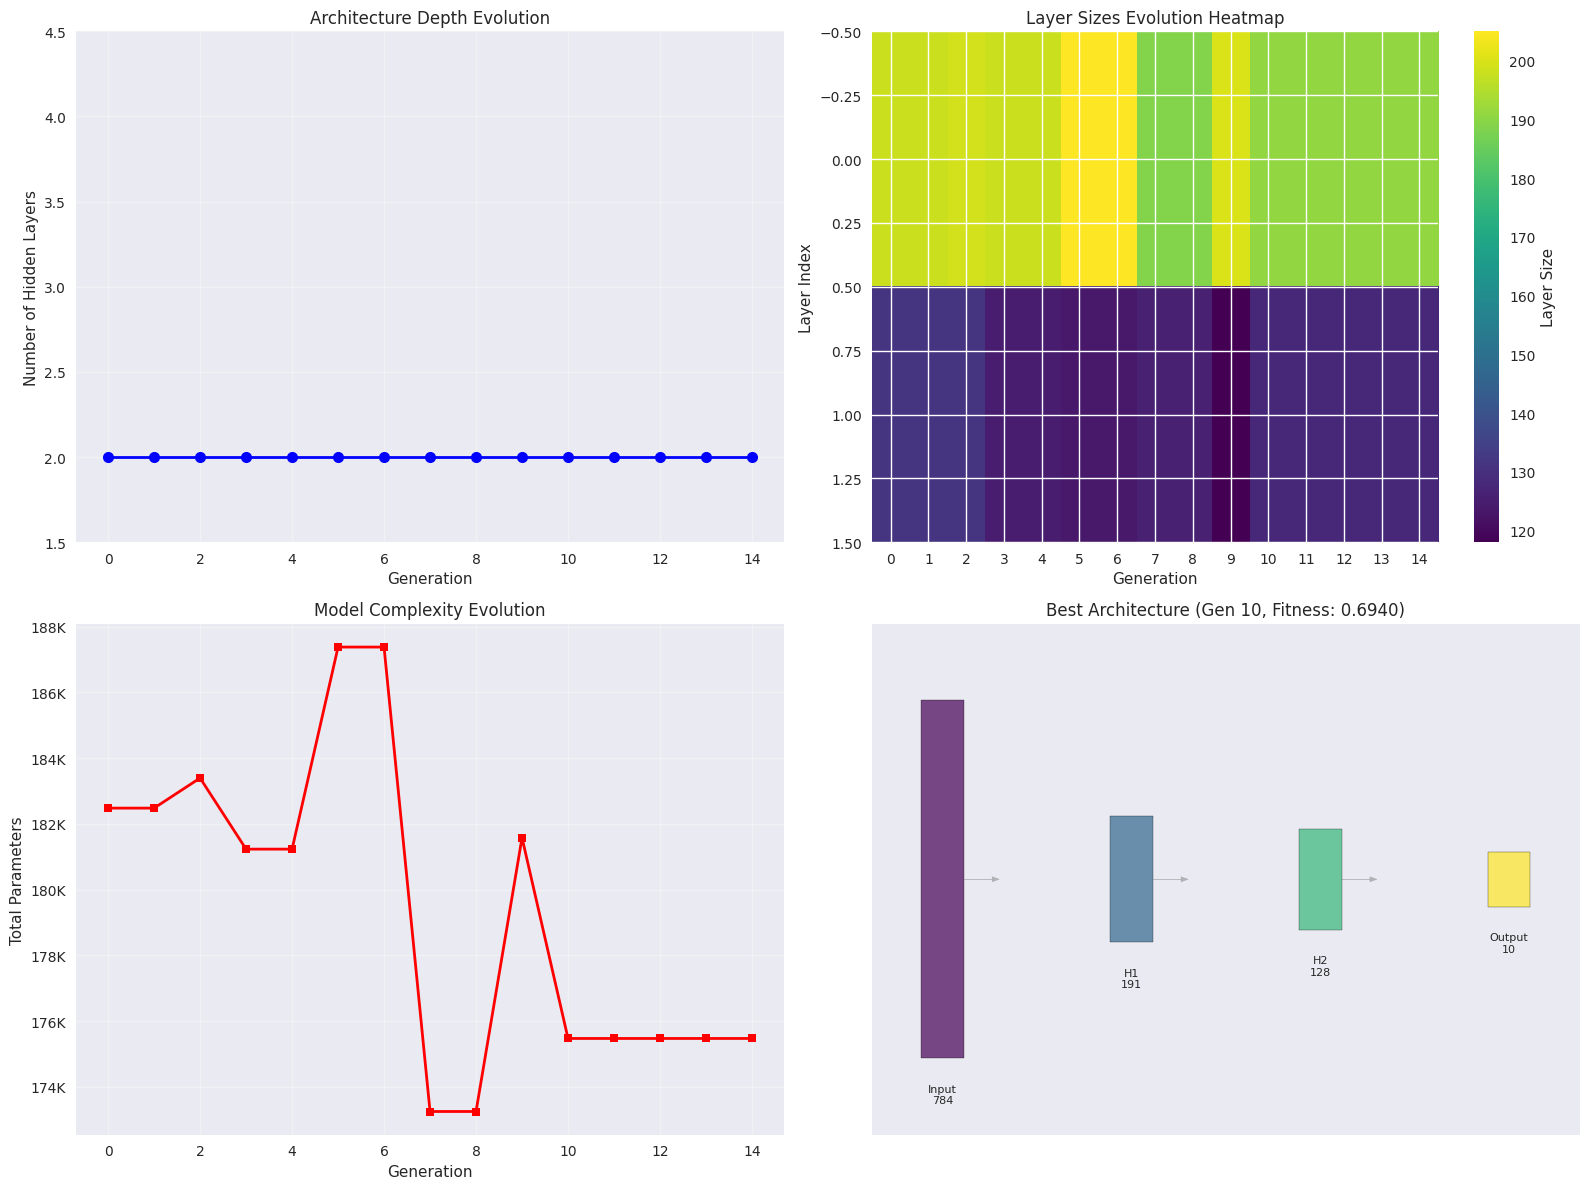

3. Beta Evolution Plot...


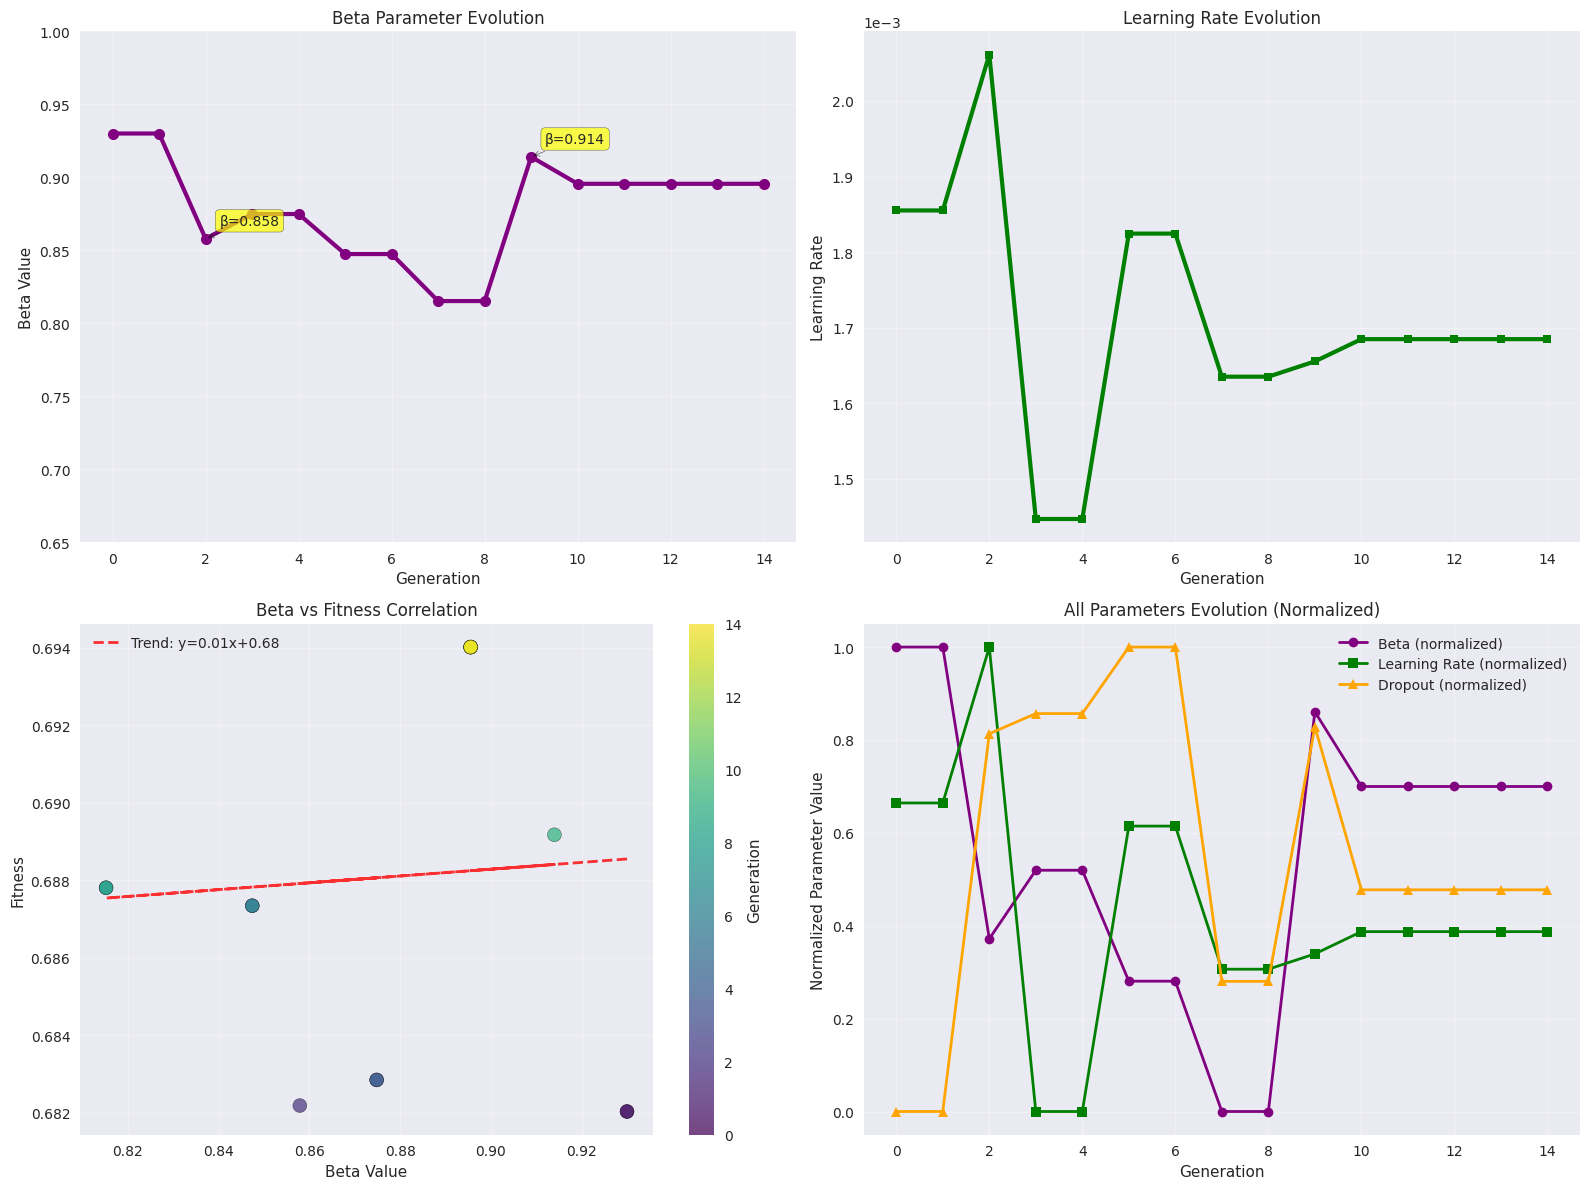

4. Comprehensive Summary Plot...


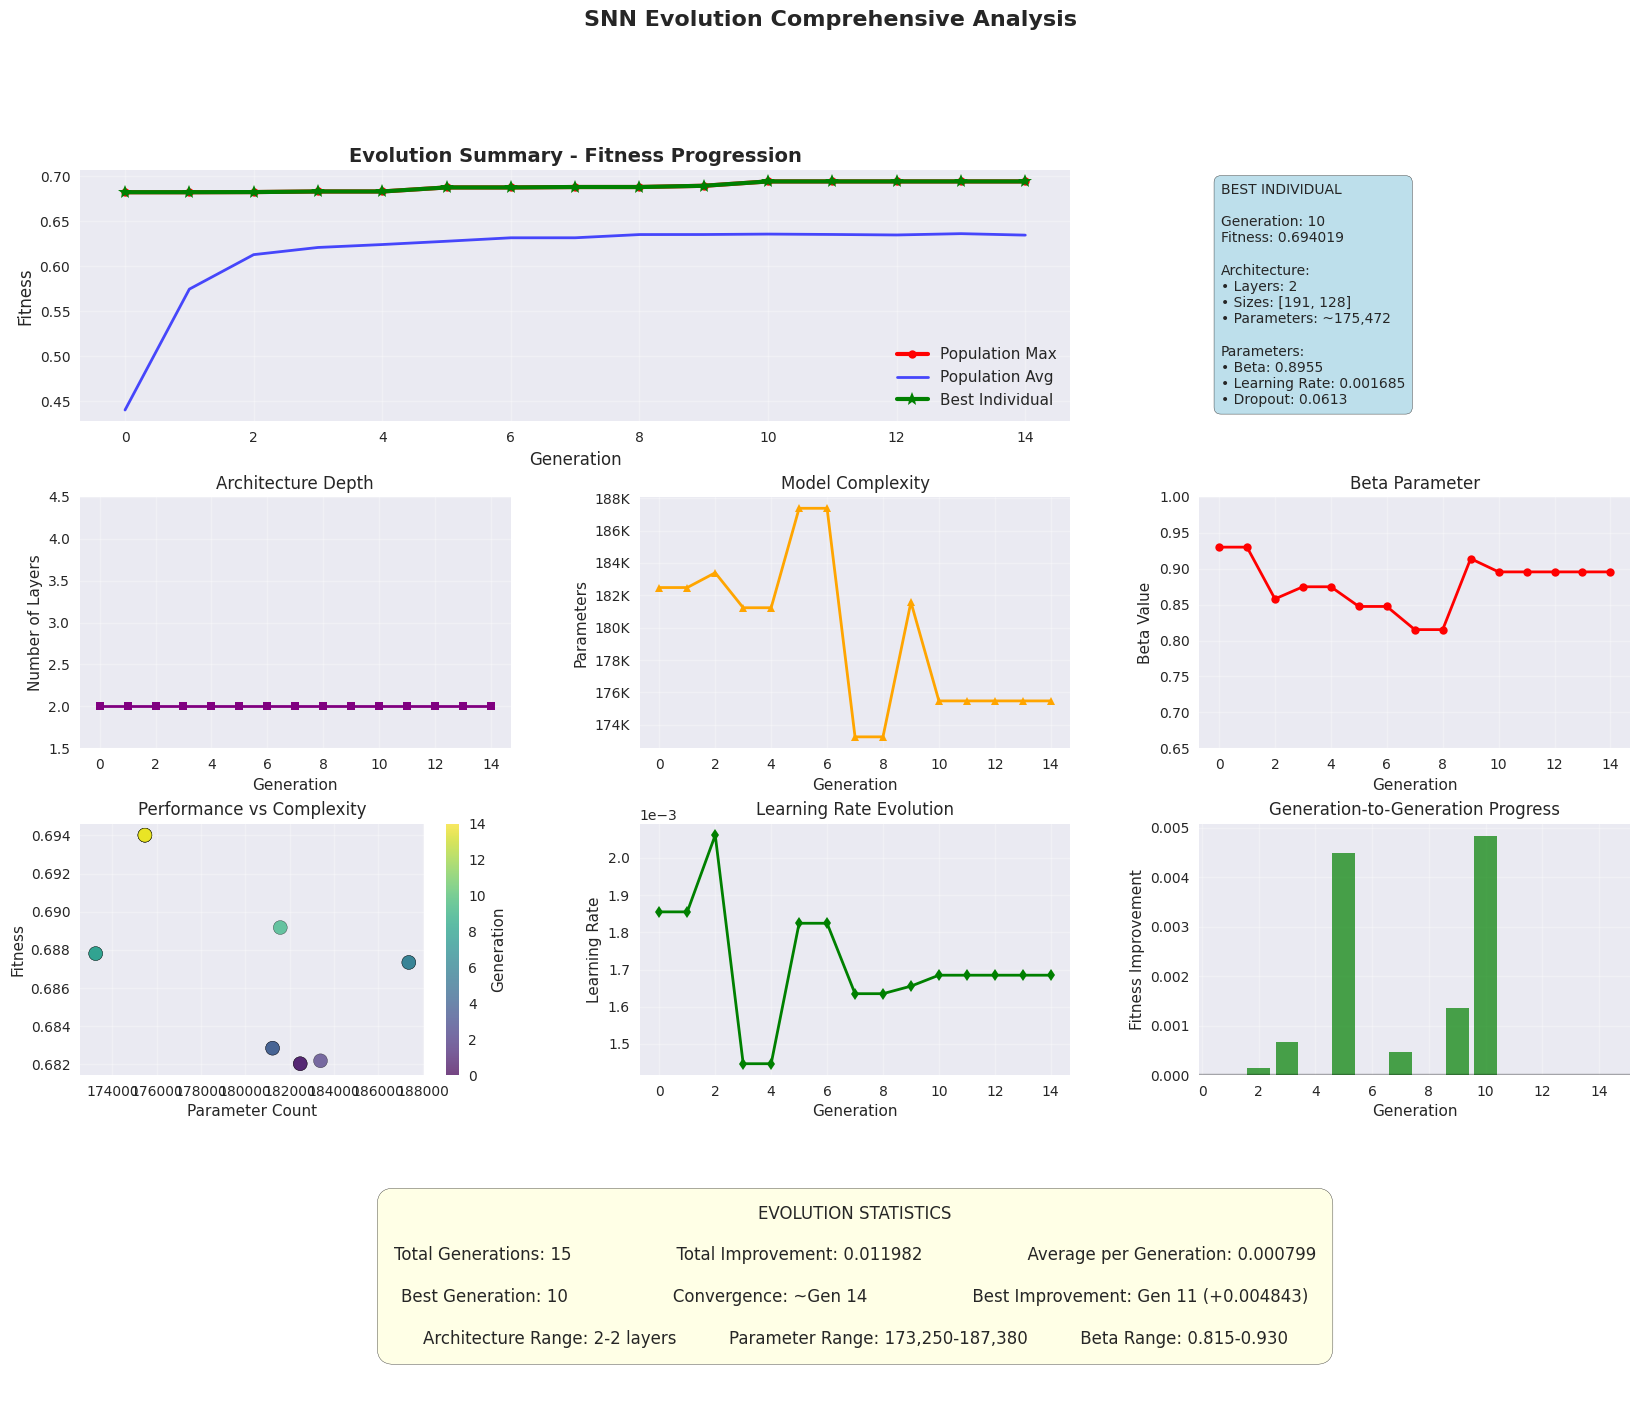

All plots saved successfully!


In [ ]:
def run_evolution():
    """Enhanced evolution with detailed best individual tracking and plotting"""
    pop_size = 50
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(pop_size/10)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    stats.register("min", np.min)
    stats.register("std", np.std)
    
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + stats.fields

    # Store best individuals from each generation
    generation_best = []
    # Store populations for each generation
    populations = []

    print("Starting Evolution...")
    print("="*80)

    # Initial evaluation
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    hof.update(pop)
    populations.append(pop)  # Store initial population
    
    # Find and display best individual of generation 0
    best_ind = tools.selBest(pop, 1)[0]
    generation_best.append((0, best_ind.copy(), best_ind.fitness.values[0]))
    print_best_individual(0, best_ind, best_ind.fitness.values[0])
    
    record = stats.compile(pop)
    logbook.record(gen=0, nevals=len(pop), **record)
    print(f"\nGen 0 Stats:\n {logbook.stream}")
    
    # Evolution loop
    for gen in range(1, 31):
        print(f"\n--- Processing Generation {gen} ---")
        
        # Selection and reproduction
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        
        # Crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.6:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        
        # Mutation
        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluation
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Elitism: Keep best individuals
        pop[:] = tools.selBest(offspring + list(hof), len(pop))
        
        hof.update(pop)
        populations.append(pop.copy())  # Store current population
        
        # Find and display best individual of current generation
        best_ind = tools.selBest(pop, 1)[0]
        generation_best.append((gen, best_ind.copy(), best_ind.fitness.values[0]))
        print_best_individual(gen, best_ind, best_ind.fitness.values[0])
        
        record = stats.compile(pop)
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(f"Gen {gen} \nStats: {logbook.stream}")
        
        # Early stopping if no improvement
        if gen > 10 and logbook[-1]['max'] == logbook[-5]['max']:
            print(f"\nEarly stopping at generation {gen} due to no improvement")
            break
    
    # Add population information to logbook
    for i, entry in enumerate(logbook):
        entry['population'] = populations[i]
    
    # Final summary
    print("\n" + "="*80)
    print("EVOLUTION COMPLETE - FINAL SUMMARY")
    print("="*80)
    
    # Print overall best
    best_overall = max(generation_best, key=lambda x: x[2])
    best_gen, best_ind, best_fitness = best_overall
    
    print(f"\nOVERALL BEST INDIVIDUAL (from Generation {best_gen}):")
    print_best_individual("FINAL", best_ind, best_fitness)
    
    # Print evolution summary
    print(f"\nEvolution Summary:")
    print(f"- Total Generations: {gen}")
    print(f"- Population Size: {pop_size}")
    print(f"- Best Fitness Achieved: {best_fitness:.6f}")
    print(f"- Best Found in Generation: {best_gen}")
    
    # Generate all plots
    print("\nGenerating plots...")
    
    print("1. Evolution Progress Plot...")
    plot_evolution_progress(logbook, generation_best)
    
    print("2. Architecture Evolution Plot...")
    plot_architecture_evolution(generation_best)
    
    print("3. Beta Evolution Plot...")
    plot_beta_evolution(generation_best)
    
    print("4. Comprehensive Summary Plot...")
    create_comprehensive_summary_plot(logbook, generation_best)
    
    print("All plots saved successfully!")
    
    return pop, logbook, hof, generation_best
if __name__ == '__main__':
    population, logbook, hall_of_fame, best_individuals = run_evolution()